In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import *
from scipy.optimize import minimize


# hand made functions
sys.path.append("../../modules")
from Rouss import *

sys.path.append("../../Model_val/upscalling/")
from upscalling_functions import *

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "working"
model_name = "first_2D"
exe_name="../../exe/mf6"

In [3]:
# some paths (mnt + rivers)
MNT_path="../../data/surfaces_geoter_decoup/TOPO (inf 0 en mer).asc"
Agly_path= "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path= "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

In [4]:
top,BOT,idomain,delr,delc = read_pickle("working/export_dis")

In [5]:
# estimate total volume of the aquifer
thk = top-BOT
thk[thk==50]=None
thk[:,130:]=None

# volume total
0.2*np.nansum(thk*300*300)/1000/1000/1000

23.161384140800003

In [6]:
#spatial parameters + grid
x0,x1,y0,y1 = Raster.load(MNT_path).bounds

ncol = idomain.shape[1]
nrow = idomain.shape[0]
nlay = 1
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data
ix = GridIntersect(grid)

In [7]:
# Do a list of all active cells
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if idomain[irow,icol] == 1: # if cell is active --> store it in lst_domain
                lst_domain.append((ilay,irow,icol))
                
idomain = idomain.reshape(nrow*ncol)

In [8]:
# BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/sea_bc_extended.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active (idomain_active=True)
lst_chd = gp2cellids(grid,BC_sea,idomain,idomain_active=True,type="polygon")

# attribute a constant head at all the cells in the lst_chd
CHD = 0.1; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [9]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.SHP"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")] # merge two ponds

# extract cellids from the BC 
etangs_chd = gp2cellids(grid,etangs.dissolve(by="NATURE"),idomain)

# create a list suited for the drn package
elev = 0; et_lst=[];
for x in etangs_chd:
    et_lst.append((x,elev,1)) #(cellid, drn elev, conductance)

In [10]:
# recharge
rch_path="../../data/recharge/recharge_p.tif" # path to rch
rch_path_2050 = "../../data/changements_clim/rast_rch_2050.tif"
rch_path_2080 = "../../data/changements_clim/rast_rch_2080.tif"

## select recharge (0 : today, 1 : 2050, 2 : 2080)
i = 0
if i == 1:
    rch_path = rch_path_2050
if i == 2:
    rch_path = rch_path_2080

rcha = rspl_rast(rch_path,grid) # resample raster to grid
rcha[rcha<0]=np.mean(rcha[rcha>0]) # replace negative values by the mean

idomain = idomain.reshape(nrow,ncol)
rcha[idomain!=1]=0 # remove some rch
for cell in etangs_chd: # remove rch in sea and ponds
    rcha[cell[1],cell[2]]=0
for cell in lst_chd:
    rcha[cell[1],cell[2]]=0
    
rcha = liss_mob(rcha,5)# moving average

idomain = idomain.reshape(nrow*ncol)

In [11]:
#import rivers with this incredible function :) (quite slow btw)

#BC Agly
Agy_chd = Complete_riv(Agly_path,"../../data/Fleuves/stations_agly.csv",us=28,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
# BC Tet
Tet_chd = Complete_riv(Tet_path,"../../data/Fleuves/stations_tet2.csv",us=180,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
#BC Boul
Bol_chd = Complete_riv(Bol_path,"../../data/Fleuves/stations_bol.csv",us=180,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
## BC Reart
Rea_chd = Complete_riv(Rea_path,"../../data/Fleuves/stations_reart.csv",us=130,ds=0,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
## BC Cant
Cant_chd = Complete_riv(Cant_path,"../../data/Fleuves/stations_cant.csv",us=135,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
# BC Tech
Tech_chd = Complete_riv(Tech_path,"../../data/Fleuves/stations_tech.csv",us=170,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

In [12]:
# change chd list in a riv list style
lst_riv_chd=[Agy_chd,Tech_chd,Cant_chd,Rea_chd,Tet_chd,Bol_chd]
cond = [0.005,0.005,0.005,0.005,0.005,0.005]

for iriv in range(len(lst_riv_chd)):
    chd2riv(lst_riv_chd[iriv],cond[iriv],2)

In [13]:
# AEP extraction
path = "../../data/prélèvements/donnees_sandra/SynthèseSLanini_data_Prelevements_1987-2018.shp"
V_col = "VOL_2013" # which column contain extraction infos
GDB = gp.read_file(path)
GDB = GDB[(GDB["USAGES"] != "IRRIGATION") & (GDB["geometry"] != None)] # remove extraction for Irrigation and where no coordinates are provided
layer = 0 # on which layer

stress_data_well = importWells(GDB,grid,lst_domain,V_col=V_col,layer=layer)

In [14]:
# recharge irrig
irr_path = "../../data/recharge/rast_irr.asc"
irr = rspl_rast(irr_path,grid)
irr[irr<0]=0

#apply coefficient (btw 0.8 and 2)
coeff = 1
irr *= coeff

irr *= 1/1000/365/86400
irr_a = irr

In [15]:
# prélèvements agricoles
path_Q = "../../data/prélèvements/prlvm_agri_Q.asc"
path_P = "../../data/prélèvements/prlvm_agri_P.asc"
p_agri_Q = rspl_rast(path_Q,grid)
p_agri_P = rspl_rast(path_P,grid)
p_agri_Q *= 1.25 # 20 % loss
p_agri_P *= 1.25 # 20 % loss
p_agri = p_agri_Q+p_agri_P

# make a list for rch package
p_agr=[]

for icell in lst_domain:
    irow = icell[1]
    icol = icell[2]
    if p_agri[irow,icol] != 0:
        p_agr.append(((icell),p_agri[irow,icol]/1000/365/86400))

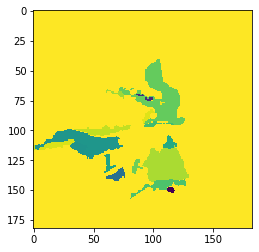

In [16]:
plt.imshow(p_agri)

In [17]:
# permeability

### Really slow, grid intersect should be avoided with big polygon --> gridgen is better ###

# initialize arrays that will define the position of the formations
idomainQ_rec = np.zeros([nrow*ncol])
idomainQ_a = np.zeros([nrow*ncol])
idomainPlio = np.zeros([nrow*ncol])

pathQr = "../../data/shp/entités/Alluv_rec.shp" # shapefile of the Quaternary formations
pathQa = "../../data/shp/entités/Alluv_anc.shp" #...
pathP = "../../data/shp/entités/Pliocene.shp"
lstIDQ_rec = gp2cellids(grid,gp.read_file(pathQr),idomainQ_rec,areas=10) #create the domains of each shp
lstIDQ_anc = gp2cellids(grid,gp.read_file(pathQa),idomainQ_a,areas=10) 
lstIDQPlio = gp2cellids(grid,gp.read_file(pathP),idomainPlio,areas=10)

In [60]:
# define k, different for each lithology
kh = 1e-5 # general k
kQr = 6.7e-5 # k for recent Quaternary
kQa = 1.24e-4 # k for ancient Quaternary
kp = 1.7e-5 # k for pliocene

pos_zones = np.zeros([nlay,nrow,ncol])
k = np.ones([nlay*nrow*ncol])*kh # vector containing the permeability array(layer,nrow,ncol)
k[idomainPlio==1] = kp
k[idomainQ_rec==1] = kQr
k[idomainQ_a==1] = kQa

k = k.reshape(nlay,nrow,ncol)
add_zone = 1 # add_zone = 1 to add the 2 conductivity zones
if add_zone == 1:
    

    ###### zone sud peu perméable
    z1 = [(689e3,616e4),(695e3,616.3e4),(700e3,616.3e4),(700e3,615.2e4),(689e3,615.2e4)]
    layer = 0
    kn = 2.12e-5
    k_zones (k,z1,layer,kn,ix) # change k with new kn value in the z1 zone at layer indicates, ix is the gridintersect object
    k_zones(pos_zones,z1,layer,1,ix)

    #### permeabilité de la zone Villeneuve
    x0_d,y0_d,x1_d,y1_d = 690e3,616.5e4,700e3,617.3e4
    zv = [(x0_d,y0_d),(x0_d,y1_d),(x1_d,y1_d),(x1_d,y0_d)]
    layer = 0
    kn = 5.69e-6
    k_zones(k,zv,layer,kn,ix)
    k_zones(pos_zones,zv,layer,2,ix)

# store k in an external file
np.savetxt(os.path.join(model_dir,"k.txt"),k[0])

In [21]:
# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using this function (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
Control_pz = importControlPz(piez_path,grid,sheetName="2012",np_col="NP_Avril2013",x_col="x",y_col="y")

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [22]:
# Corbières
layer = 0
BDcells = cellidBD(idomain.reshape(nlay,nrow,ncol),layer)
poly = Polygon([(685e3,618.7e4),(685e3,619.5e4),(696e3,619.5e4),(696e3,618.7e4)])

Corb_spd = []
Corb_lst = []
flux = 0.2
res = ix.intersect_polygon(poly)
for cellid in res.cellids:
    cell = (layer,cellid[0],cellid[1])
    if cell in BDcells:
        Corb_lst.append(cell)
n_cells = len(Corb_lst)

for cell in Corb_lst:
    Corb_spd.append((cell,flux/n_cells))

In [23]:
## Thuir
layer = 0
poly = Polygon([(674e3,616.8e4),(674e3,617.4e4),(678e3,617.4e4),(678e3,616.8e4)])

plio_chd = []
for cellid in ix.intersect_polygon(poly).cellids:
    cell = (layer,cellid[0],cellid[1])
    if cell in BDcells:
        plio_chd.append((cell,120))

In [61]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='first2D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=BOT,xorigin=x0,yorigin=y0,idomain=idomain)
tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=BOT+1)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('BUDGET', 'ALL')])

# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=["k.txt"], save_flows=True,save_specific_discharge=True)

# recharge
rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = rcha/1000/365/86400,save_flows=True)
   
p_ag = fp.mf6.ModflowGwfrch(gwf,pname="p_ag",filename="p_ag.rch",maxbound=len(p_agr),stress_period_data={0 : p_agr},save_flows=True)

irr = fp.mf6.ModflowGwfrcha(gwf,pname="irr",filename="irr.rch",recharge=irr_a,save_flows=True)

# well package
wel = fp.mf6.ModflowGwfwel(gwf, pname="wel",filename="wel.wel",
                           stress_period_data=stress_data_well, maxbound=len(stress_data_well),save_flows=True)

#Corb
Corb = fp.mf6.ModflowGwfwel(gwf,pname="Corb",filename="Corb.wel",maxbound=len(Corb_spd),
                            stress_period_data=Corb_spd,save_flows=True)

#Thuir
thuir = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='thuir', filename="thuir.chd", maxbound=len(plio_chd), 
                                                       stress_period_data={0: plio_chd}, save_flows=True)

# constant heads packages
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

#rivers
etangs = fp.mf6.modflow.ModflowGwfdrn(gwf, pname='eta', filename="eta.drn", maxbound=len(et_lst), 
                                               stress_period_data={0: et_lst}, save_flows=True)

Riv1 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='agy', filename="agy.chd", maxbound=len(Agy_chd), 
                                              stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tet', filename="Tet.chd", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Rea', filename="Rea.chd", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Cant', filename="Cant.chd", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tech', filename="Tech.chd", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Bol', filename="Bol.chd", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)

In [62]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model first_2D...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha...
    writing package p_ag...
    writing package irr...
    writing package wel...
    writing package corb...
    writing package thuir...
    writing package sea...
    writing package eta...
    writing package agy...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This so

(True, [])

In [3]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

# retrieve the chd package name
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])
    

NameError: name 'ml' is not defined

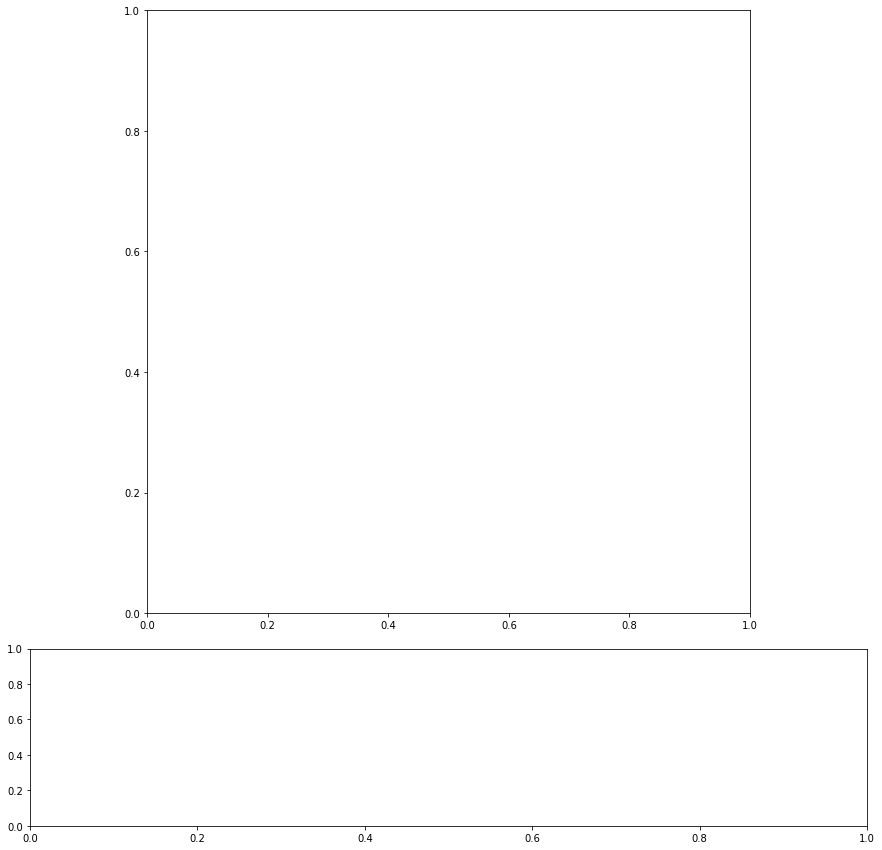

In [4]:
fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

layer= 0
ml = fp.plot.PlotMapView(model=sim.gwf,layer=layer)

ax1 = fig.add_subplot(grid[0:3,:],aspect="equal") # head plot
ax2 = fig.add_subplot(grid[3:,:]) # cross section plot

hmesh=ml.plot_array(head,masked_values=[0,1e30],cmap="viridis",ax=ax1)
hmesh.set_clim(0,180)
#ml.plot_specific_discharge(spdis[0],color="w",width=0.0050)
cont=ml.contour_array(head,masked_values=[0,1e30],levels=np.linspace(0,170,18),colors="k",ax=ax1)
plt.clabel(cont,fmt="%1i")

# plot bc
for bc in bdfile:
    if bc == ("sea") or bc== ("eta"):
        ml.plot_bc(bc,color="b",alpha=0.5,ax=ax1)
    if bc == ("thuir"):
        ml.plot_bc(bc,color="k",ax=ax1)
    if bc == ("thuir"):
        ml.plot_bc(bc,color="k",ax=ax1)
    else : 
        ml.plot_bc(bc,color="lightblue",alpha=0.5,ax=ax1)
ml.plot_bc("wel",ax=ax1) # plot the wells  
ml.plot_bc("Corb",ax=ax1,color="green") # plot the wells 

# plot Cross-section on head map
row = 130
x = [x0,x1]
y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
ax1.plot(x,y,"k",linewidth=3)

ax1.tick_params(labelsize=15)
ax1.grid()

# Cross section
x=fp.plot.PlotCrossSection(gwf,line={"row" :row})
arr=x.plot_array(head,masked_values=[1e30],head=head,ax=ax2)
#plt.colorbar(arr)
arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid()
ax2.set_ylim(-400,220)
ax2.set_xlim(1.3e4,6e4)


cbaxes = fig.add_axes([0.95, 0.15, 0.03, 0.8]) 
cb = plt.colorbar(arr, cax = cbaxes)  

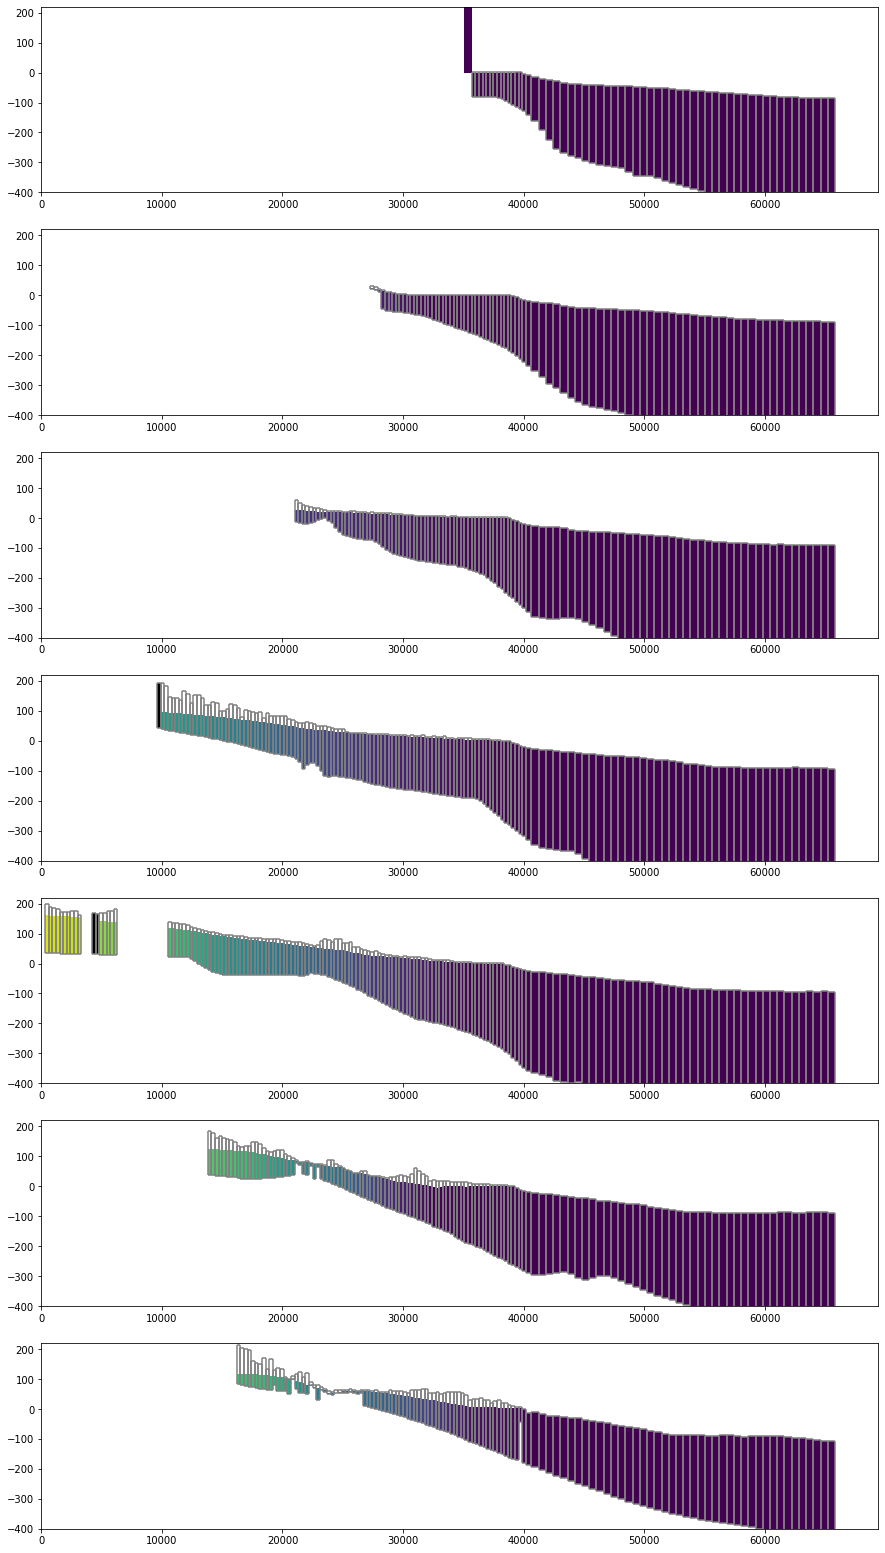

In [145]:
## pleins de cross sections horizontales

n=7 # nombre de cross à faire
fig,ax = plt.subplots(n,1,figsize=(15,4*n))
# Cross section
row = 30
for axi in ax:
    x=fp.plot.PlotCrossSection(gwf,line={"row" :row})
    arr=x.plot_array(head,masked_values=[1e30],head=head,ax=axi)
    #plt.colorbar(arr)
    arr.set_clim(0,170)
    x.plot_ibound(ax=axi)
    x.plot_grid(ax=axi)
    axi.set_ylim(-400,220)
    #axi.set_xlim(1.3e4,6e4)
    row+=150/n

Text(0, 0.5, 'm3/s')

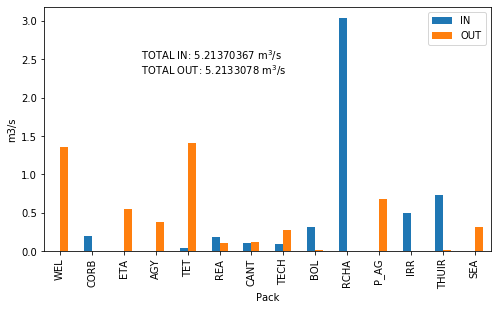

In [66]:
fig,ax = plt.subplots(figsize=(8,4.5))
Budget = get_Total_Budget(model_name,model_dir)
Budget.set_index("Pack").plot(kind="bar",ax=ax)
ax.text(2.55,2.5,"TOTAL IN: {} m$^3$/s".format(Budget.sum()["IN"]));
ax.text(2.55,2.3,"TOTAL OUT: {} m$^3$/s".format(Budget.sum()["OUT"]));
ax.set_ylabel("m3/s")

(0, 200)

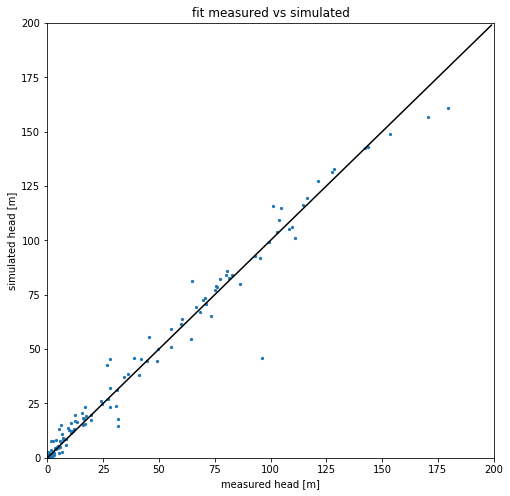

In [67]:
# retrieve heads and spdis 
fig = plt.figure(figsize=(8,8))

head = get_heads(model_name,model_dir)
head[head>1000]=None

plt.scatter(Control_pz[Control_pz!=0],
            head[0][Control_pz!=0],s=5)
plt.plot(np.arange(-10,200),np.arange(-10,200),"k")
plt.xlabel("measured head [m]")
plt.ylabel("simulated head [m]")
plt.title("fit measured vs simulated")
plt.xlim(0,200)
plt.ylim(0,200)

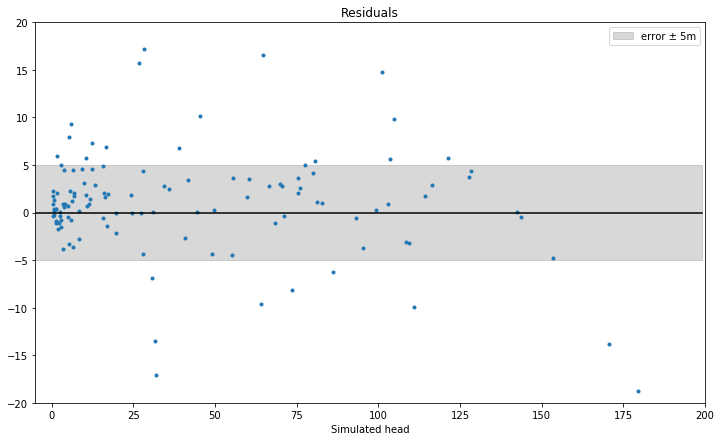

In [68]:
#residuals
fig = plt.figure(figsize=(12,7))
plt.plot((Control_pz[Control_pz!=0]),(head[0][Control_pz!=0]-Control_pz[Control_pz!=0]),".")

xfit = np.arange(-10,200)
yfit = np.zeros([210])
dyfit = 5
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit,
                 color='gray', alpha=0.3,label="error ± 5m")
plt.plot(xfit,yfit,"k")
plt.xlim(-5,200)
plt.ylim(-20,20)
plt.title("Residuals")
plt.xlabel("Simulated head")
plt.legend()

In [69]:
Misfit = np.abs((Control_pz[Control_pz!=0] - head[0][Control_pz!=0]))
print("Misfit : {} m ".format(np.nanmean(Misfit)))

Misfit2 = (np.nansum((((Control_pz[Control_pz!=0] - head[0][Control_pz!=0])**2)/Control_pz[Control_pz!=0].shape[0])))**0.5
print("RMSE : {}".format(Misfit2))

phi = np.nansum((Control_pz[Control_pz!=0] - head[0][Control_pz!=0])**2)
print("phi : {}".format(phi))

Misfit : 4.077627783502295 m 
RMSE : 7.077738125873709
phi : 6211.702745327339


In [ ]:
def Misfit(kh):
    
    fp.mf6.mfpackage.MFPackage(gwf,package_type="npf").remove()# remove pre-existing npf package
    
    k = np.ones([nrow*ncol])*1e-5 # vector containing the permeability array(layer,nrow,ncol)
    k[idomainPlio==1] = kh[0]
    k[idomainQ_rec==1] = kh[1]
    k[idomainQ_a==1] = kh[2]
    
#     k = k.reshape(nlay,nrow,ncol)
#     ###### zone sud peu perméable
#     z1 = [(689e3,616e4),(695e3,616.3e4),(700e3,616.3e4),(700e3,615.2e4),(689e3,615.2e4)]
#     layer = 0
#     kn = kh[3]
#     k_zones (k,z1,layer,kn,ix) # change k with new kn value in the z1 zone at layer indicates, ix is the gridintersect object

#     #### permeabilité de la zone Villeneuve
#     x0_d,y0_d,x1_d,y1_d = 690e3,616.5e4,700e3,617.3e4
#     zv = [(x0_d,y0_d),(x0_d,y1_d),(x1_d,y1_d),(x1_d,y0_d)]
#     layer = 0
#     kn = kh[4]
#     k_zones(k,zv,layer,kn,ix)
    
    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k) # create the new npf package
    npf.write() # write it
    if sim.run_simulation(silent = True): # And RUN !
        head = get_heads(model_name,model_dir)
        head[head>1000]=None
    
    return np.nanmean(np.abs((Control_pz[Control_pz!=0] - head[0][Control_pz!=0])))

In [ ]:
#res = minimize(Misfit,(1.76e-5,1.4e-4,1.1e-4,1e-5,4.2e-6), method = 'Nelder-Mead')